In [1]:
from autoplot import *
import numpy as np
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft, fftfreq

# Even de working directory veranderen omdat de notebook in een andere map staat dan de data.
import os
os.chdir('2022_2023_round_09')

# Analysing the V-PHI data

For this task we first consider a single graph, to ensure everything is working correctly.

/tmp/ipykernel_259/2143627716.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


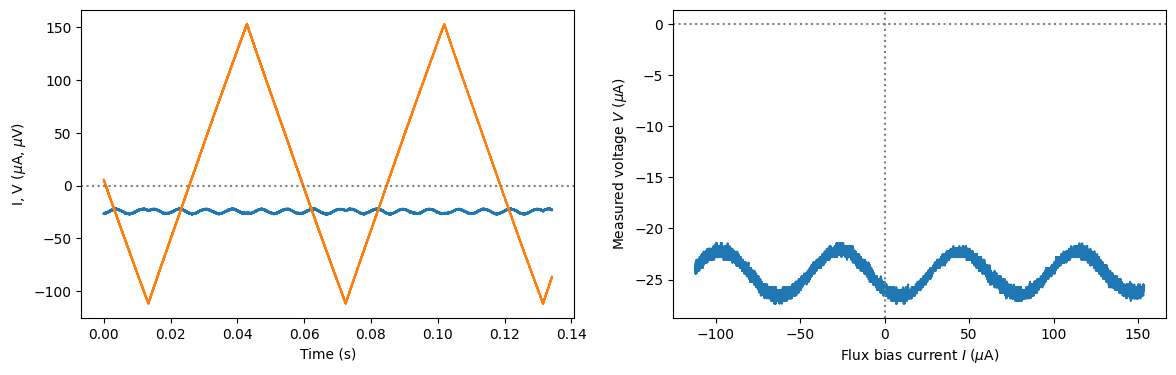

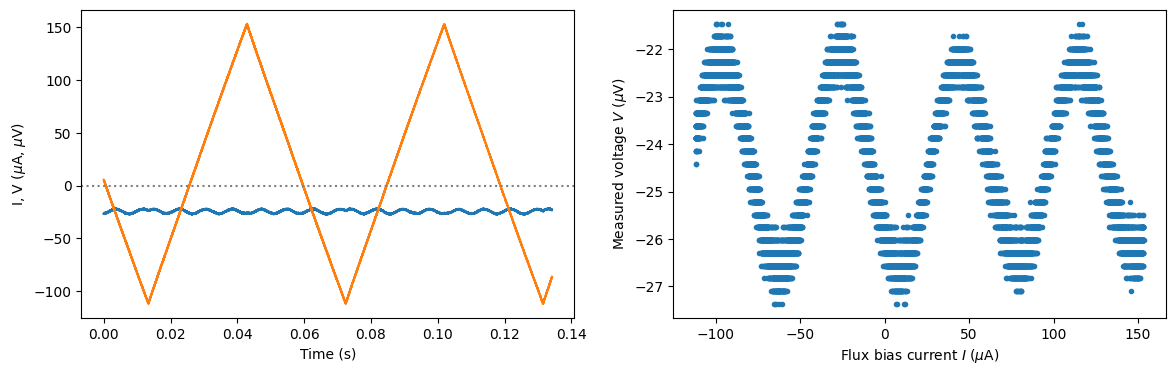

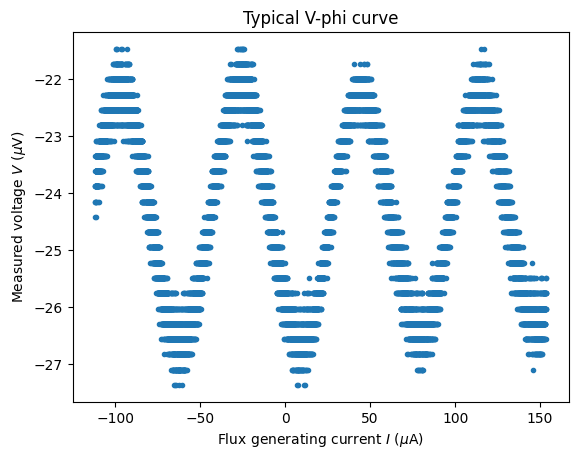

In [16]:
#plot_V_Phi('mrsquid_V-Phi_2023-02-15-16_27_34.dat')
plot_V_Phi('mrsquid_V-Phi_2023-02-22-14_53_01.dat')


#file =  "mrsquid_V-Phi_2020-10-16-12_05_03.dat"
#t,i,v = np.loadtxt(file, unpack=True)
#
#plt.subplots(figsize=(14,4))
#plt.subplot(121)
#plt.plot(t,v)
#plt.plot(t,i)
#plt.xlabel("Time (s)")
#plt.ylabel("I, V ($\mu$A, $\mu$V)")
#plt.axhline(0,ls=':',c='grey')
#plt.subplot(122)
#plt.plot(i,v)
#plt.axhline(0,ls=':',c='grey')
#plt.axvline(0,ls=':',c='grey')
#plt.xlabel("Flux bias current $I$ ($\mu$A)")
#plt.ylabel("Measured voltage $V$ ($\mu$V)")

file =  'mrsquid_V-Phi_2023-02-22-14_53_01.dat'
t,i,v = np.loadtxt(file, unpack=True)

plt.subplots(figsize=(14,4))
plt.subplot(121)
plt.plot(t,v)
plt.plot(t,i)
plt.xlabel("Time (s)")
plt.ylabel("I, V ($\mu$A, $\mu$V)")
plt.axhline(0,ls=':',c='grey')

plt.subplot(122)
plt.plot(i,v,'.')
#plt.axhline(0,ls=':',c='grey')
#plt.axvline(0,ls=':',c='grey')
#plt.savefig("/work/figures/typical V-phi curve")
plt.xlabel("Flux bias current $I$ ($\mu$A)")
plt.ylabel("Measured voltage $V$ ($\mu$V)")
plt.show()
plt.figure()
plt.plot(i,v,'.')
#plt.axhline(0,ls=':',c='grey')
#plt.axvline(0,ls=':',c='grey')
plt.xlabel("Flux generating current $I$ ($\mu$A)")
plt.ylabel("Measured voltage $V$ ($\mu$V)")
plt.title("Typical V-phi curve")
plt.savefig("/work/figures/typical V-phi curve")

plt.show()

Once again there is an issue with the voltage only being measured in certain evenly space values, maybe this is simply an artifact of the electronics? It is possible to find the period form this graph with redyuced uncertainty if we take three periods and devide the difference in current $\Delta I$ by three, since the uncertainty would also be devided by three.

Fitting a sinusoid does not work at all and neitgher does a fourier transform, so the next best way is to determine the period manually

[56.63861123 81.05647453  1.57060796 25.06610258] [28282.66344968 28282.65052507   274.89511347  4369.13886103]


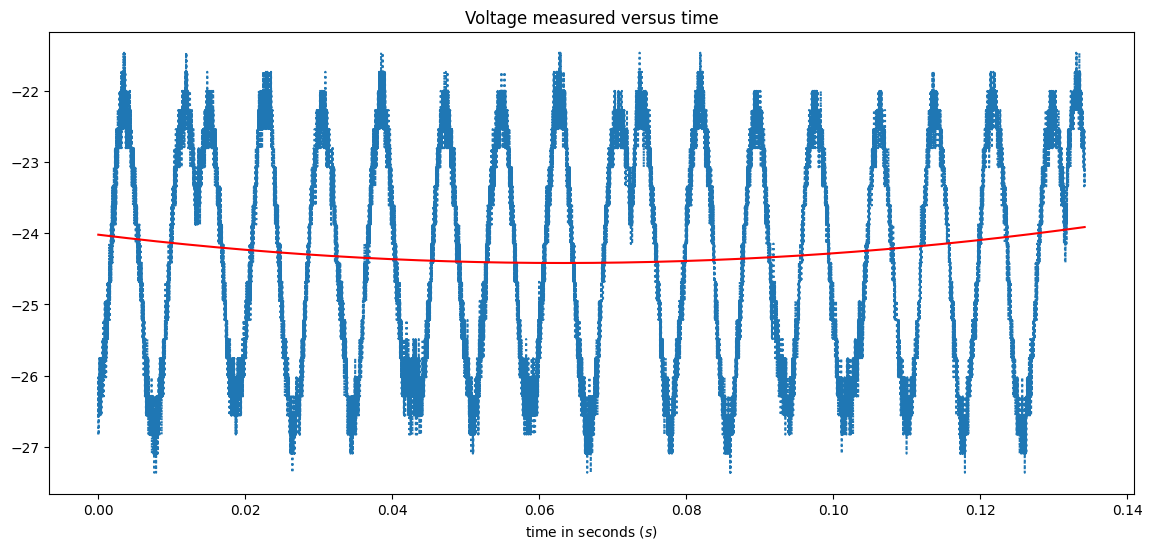

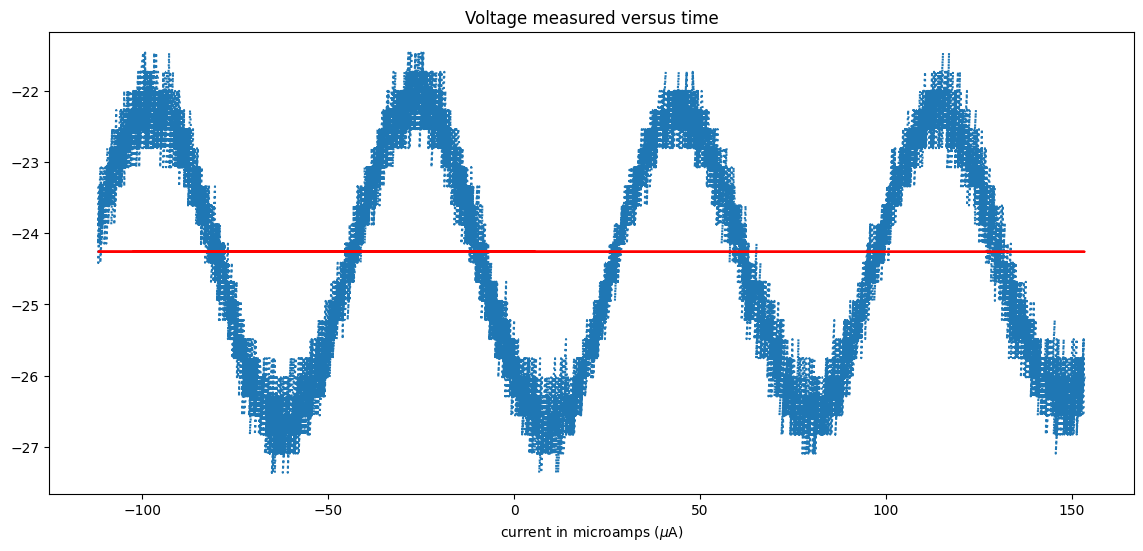

[-2.42662159e+01  1.56866020e-02  8.61471616e-01 -4.98058279e-01]
[[ 7.99909052e+08  7.99908686e+08 -7.77476571e+06  1.23570880e+08]
 [ 7.99908686e+08  7.99908321e+08 -7.77476216e+06  1.23570823e+08]
 [-7.77476571e+06 -7.77476216e+06  7.55673234e+04 -1.20105492e+06]
 [ 1.23570880e+08  1.23570823e+08 -1.20105492e+06  1.90893744e+07]]


In [3]:
def sinusoid(x,a,b,c,d):
    return(a+b*np.sin(c*(x-d)))

popt,pcov=curve_fit(sinusoid,t,v,maxfev=10000)
popt2,pcov2=curve_fit(sinusoid,i,v,maxfev=10000)

print(popt,np.sqrt(np.diag(pcov)))

#Let's plot our found function to check if the result is reasonable
plt.subplots(figsize=(14,6))
plt.subplot()
plt.plot(t,v,':',label='time $s$')
plt.plot(t,sinusoid(t,popt[0],popt[1],popt[2],popt[3]),'r')
plt.title('Voltage measured versus time')
plt.xlabel('time in seconds ($s$)')
plt.show()

plt.subplots(figsize=(14,6))
plt.subplot()
plt.plot(i,v,':',label='time $s$')
plt.plot(i,sinusoid(t,*popt2),'r')
plt.title('Voltage measured versus time')
plt.xlabel('current in microamps ($\mu$A)')
plt.show()
print(popt2)
print(pcov)

This is not a great result from the curve fit as it clearly does not fit the data. Maybe there are multiple dominant sinusoids in the graph, or there is to much noise. I am going tu use bin averaging to smooth the higher frequency noise.

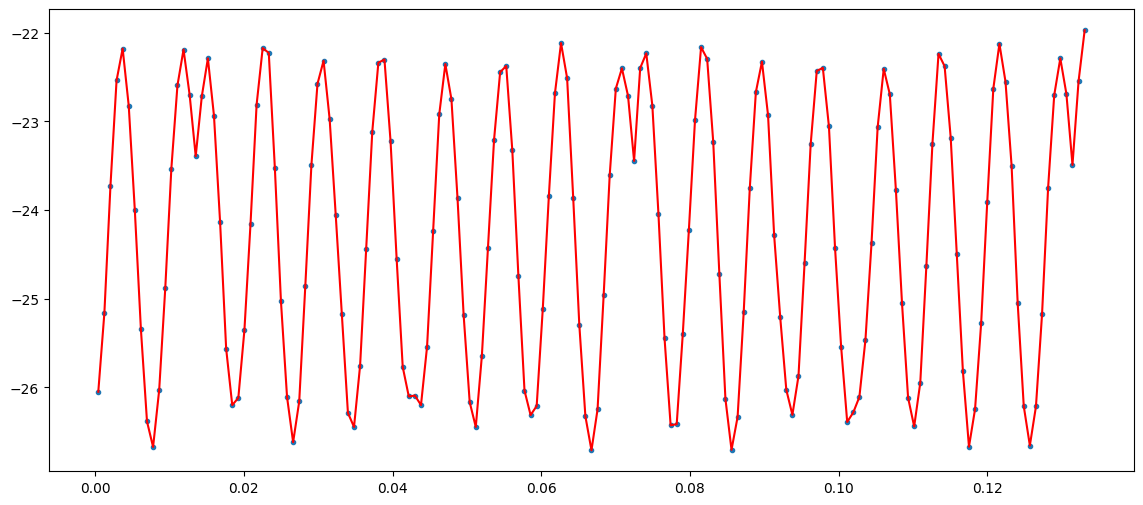

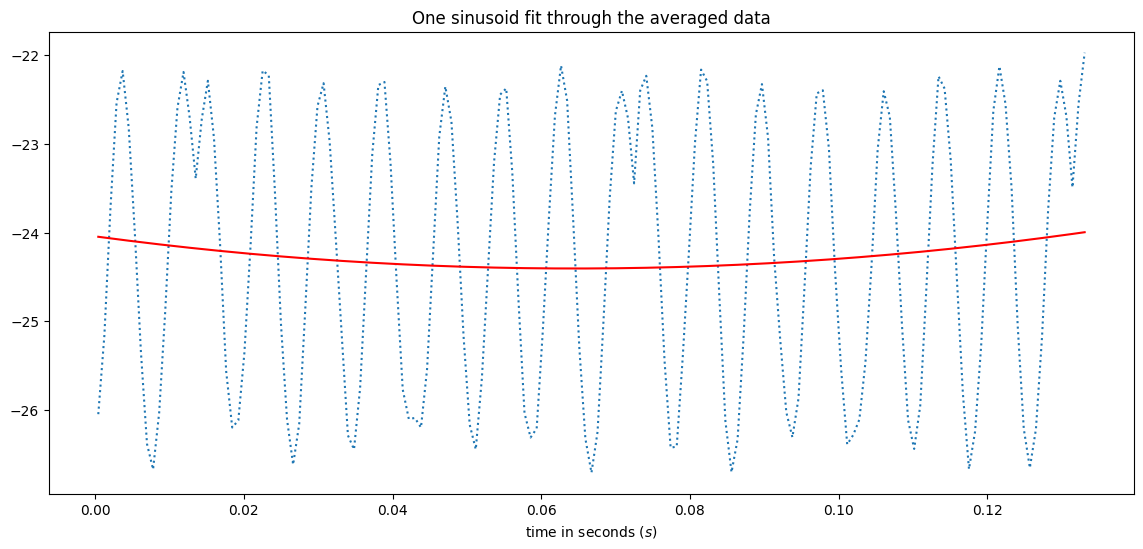

[18.4754297  42.88076082  2.01531233 41.37435562] [111686.56961977 111686.44073014   2633.14753789  53902.96943686]


In [4]:
n=100

def binaverage(x, navg):
    N = len(x) // navg
    return np.average(np.reshape(x[0:N*navg],(N,navg)),axis=1)


ind = np.argsort(t)

# Sort and filter in one step
t_f = binaverage(t[ind],n)
v_f = binaverage(v[ind],n)

plt.figure(figsize=(14,6))
plt.plot(t_f,v_f,'.')
plt.plot(t_f,v_f,'r')
plt.show()


def sin_and_linear(x,a,b,c,d,e):
    return(sinusoid(x,a,b,c,d)+x*e)
popt_f,pcov_f=curve_fit(sinusoid,t_f,v_f,maxfev=100000)
#Let's plot our found function to check if the result is reasonable
plt.subplots(figsize=(14,6))
plt.subplot()
plt.plot(t_f,v_f,':',label='time $s$')
plt.plot(t_f,sinusoid(t_f,*popt_f),'r')
plt.title('One sinusoid fit through the averaged data')
plt.xlabel('time in seconds ($s$)')

plt.show()
print(popt_f,np.sqrt(np.diag(pcov_f)))


I can't get this to work. The solution is to do it manually

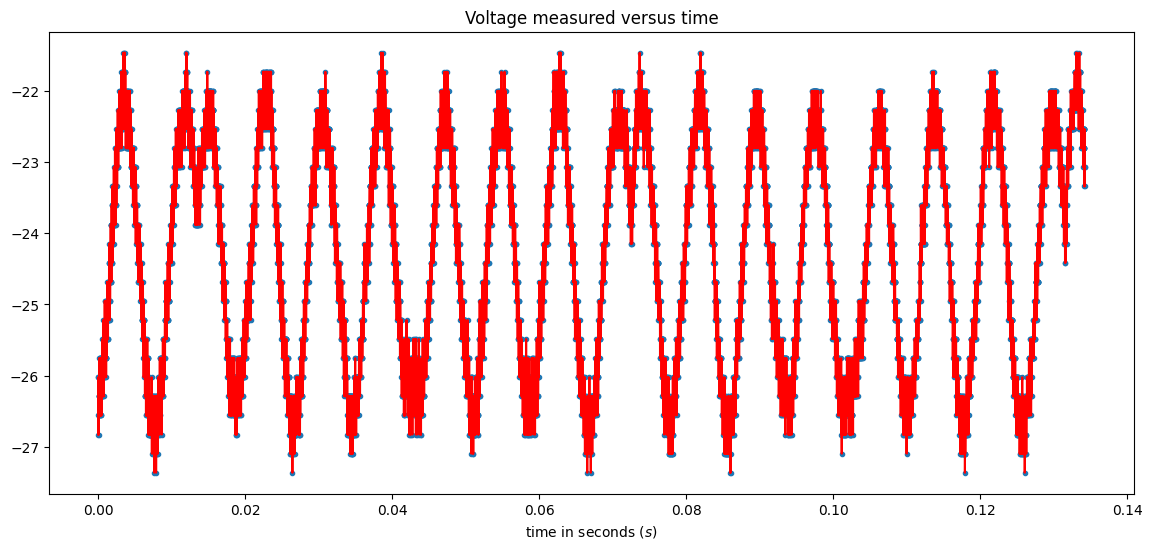

16384


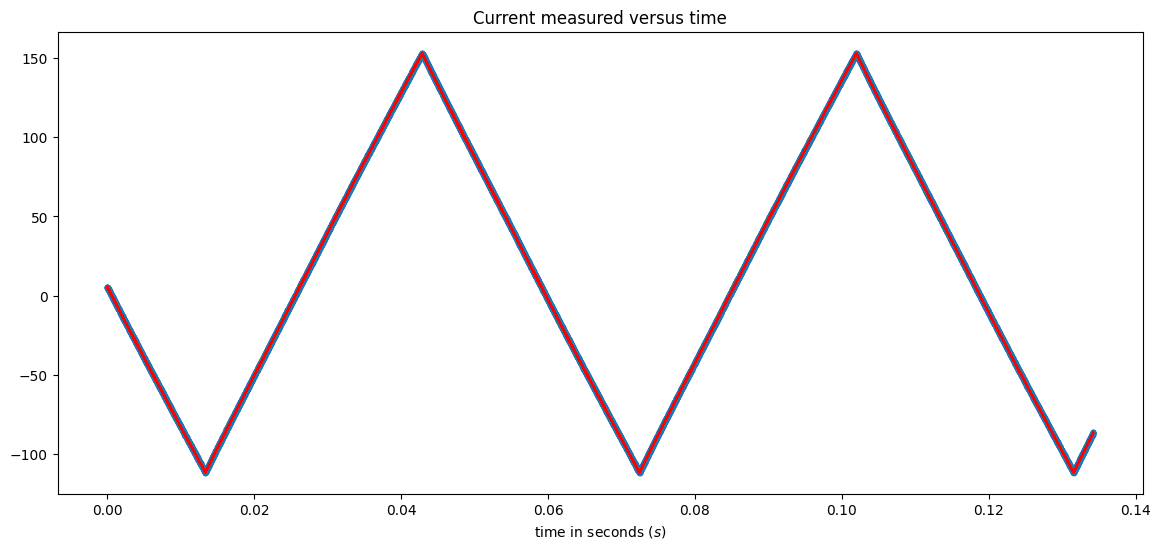

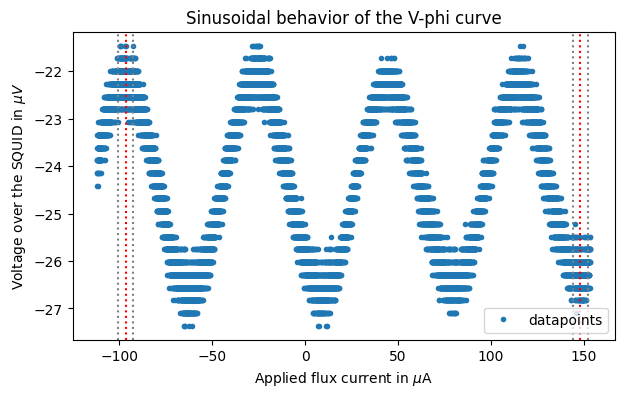

In [5]:
plt.figure(figsize=(14,6))
plt.plot(t,v,'.',label='time $s$')
plt.plot(t,v,'r',label='Interpolated data')
plt.title('Voltage measured versus time')
plt.xlabel('time in seconds ($s$)')
plt.show()
print(len(v))

plt.figure(figsize=(14,6))
plt.plot(t,i,'.',label='time $s$')
plt.plot(t,i,'r',label='Interpolated data')
plt.title('Current measured versus time')
plt.xlabel('time in seconds ($s$)')
plt.show()

u_I=4
left_bound=-96.5
right_bound=148
plt.figure(figsize=(7,4))
plt.plot(i,v,'.',label='datapoints')
#plt.plot(i,v,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")
plt.legend()
plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.savefig("/work/figures/period measurement")
plt.show()

dI_0=right_bound-left_bound #store this difference in I
N_0=3.5 #number of periods of sine wave

This data is quite noisy. Let's make it so that there are a lot of periods by summing multiple measurements together.
First let's look for what the period is of this sine wave. Using a cuve_fit does not work due to the noise. So we will have to use some arithmatic.

We can calculate the value of one flux quanta with the formula $\Phi_0=\Delta I *M$. For our SQUID the manual says M=37pH. According to the theory $\Phi_0$ is $2*10^-15$ So this leaves $\Delta I$ to be $54\mu I$.

The above graph has two local extremes of the sinusoidal pattern indicated by dotted lines. These lines represent three and a half periods of the sine wave. The left most boundry is at $-97\mu A$. The uncertainty in the estimate is $4\mu A$, indicated by the grey dotted lines. I have chosen $4\mu A$ because it is just the right value to emcompass all the highest points and most of the points of the second highest level whilst not being too conservative.
The boundry on the right side is at $148 \pm 4\mu A$. I have chosen the same uncertainty interval since it is the same measurement with the same instruments and the uncertainty is constant. This gives a difference in current, which I shall name $\Delta I$ of $245 \pm 8 \mu A$ for the three and a half period. As such, the $\Delta I$ for one period is $70 \pm 2 \mu A$. This is a significant difference from the expected value of $54\mu A$. This is due to the self-inductance of the datasheet being inaccurate. In the user manual of the mr SQUID it is mentioned that the self inductance M is only a rough estimate. So let's say that the physics is correct, that would allow us to measure  the self inductance of the probe.

Let's look at multiple datasets and determine the $\Delta I$ with more certainty first. Then we will calcualte the self inductance M of the SQUID.

In [6]:

t_1,i_1,v_1 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_53_02.dat', unpack=True)
t_2,i_2,v_2 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_53_06.dat', unpack=True)
t_3,i_3,v_3 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_53_07.dat', unpack=True)
t_4,i_4,v_4 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_56_42.dat', unpack=True)
t_5,i_5,v_5 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_57_16.dat', unpack=True)
t_6,i_6,v_6 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_57_17.dat', unpack=True)
t_7,i_7,v_7 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_57_18.dat', unpack=True)
t_8,i_8,v_8 = np.loadtxt('mrsquid_V-Phi_2023-02-22-14_57_24.dat', unpack=True)

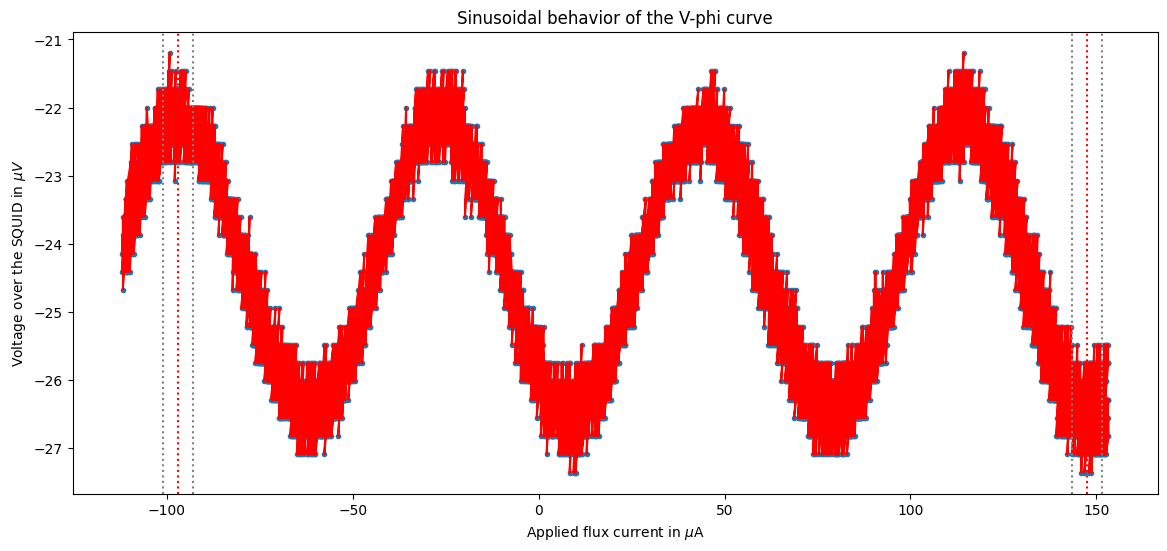

In [7]:
left_bound=-97
right_bound=147.5

plt.figure(figsize=(14,6))
plt.plot(i_1,v_1,'.',label='time $s$')
plt.plot(i_1,v_1,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_1=right_bound-left_bound
N_1=3.5

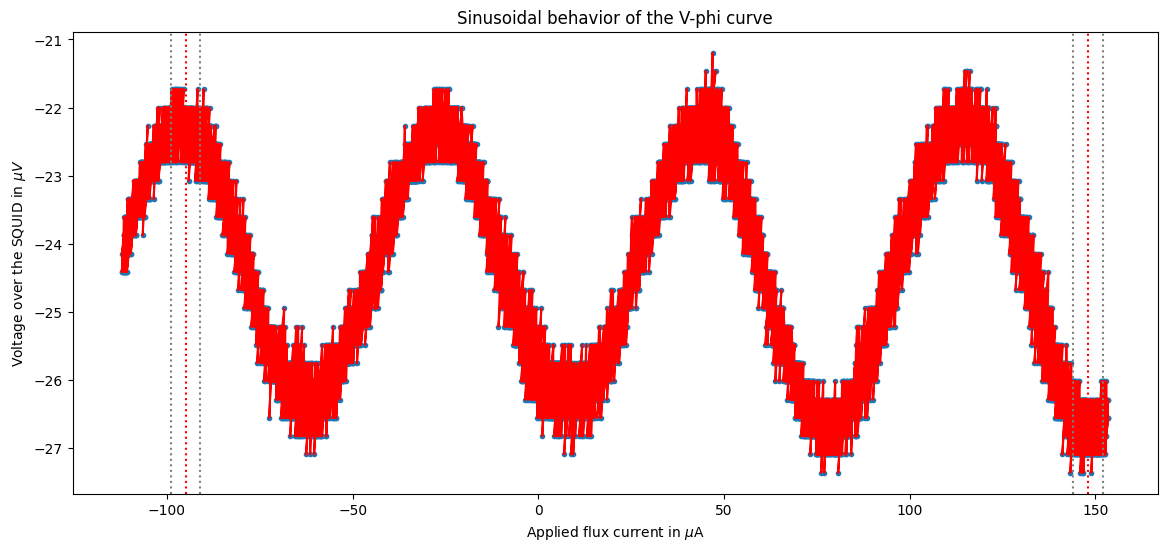

In [8]:
left_bound=-95
right_bound=148

plt.figure(figsize=(14,6))
plt.plot(i_2,v_2,'.',label='time $s$')
plt.plot(i_2,v_2,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_2=right_bound-left_bound
N_2=3.5

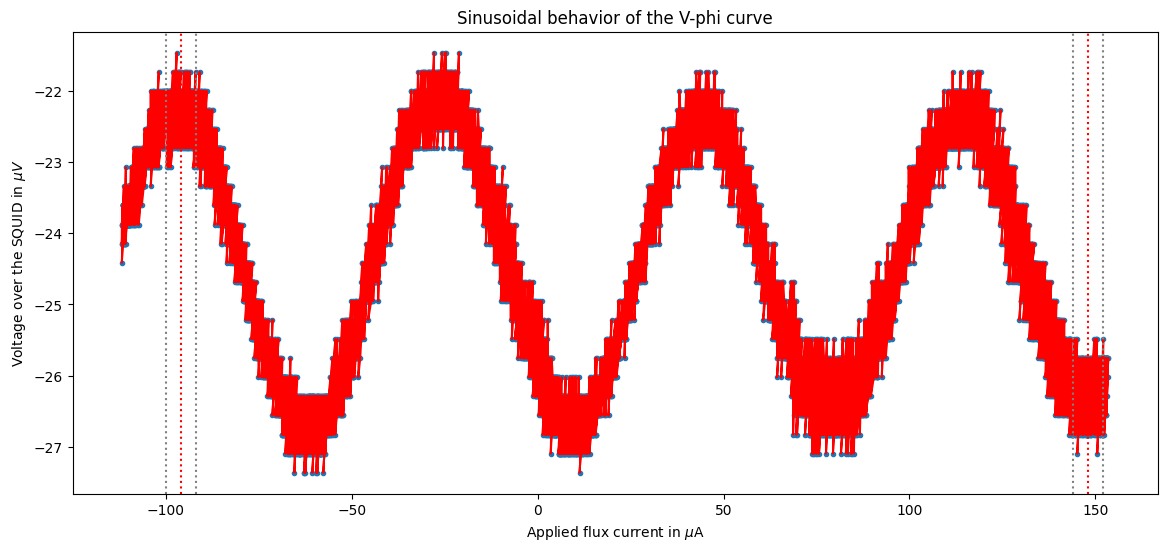

In [9]:
left_bound=-96
right_bound=148

plt.figure(figsize=(14,6))
plt.plot(i_3,v_3,'.',label='time $s$')
plt.plot(i_3,v_3,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_3=right_bound-left_bound
N_3=3.5

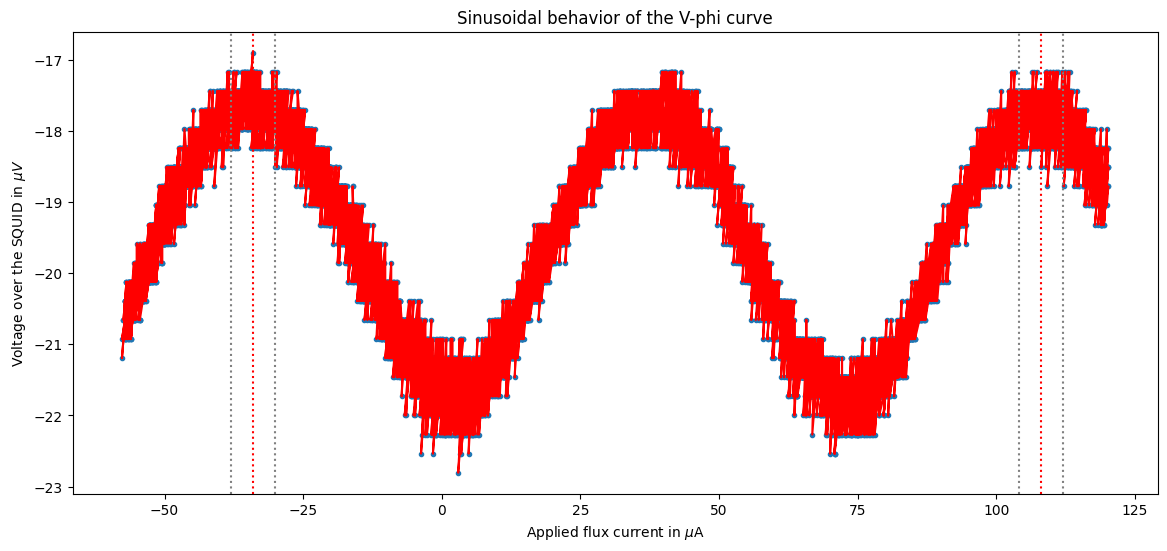

In [10]:
left_bound=-34
right_bound=108

plt.figure(figsize=(14,6))
plt.plot(i_4,v_4,'.',label='time $s$')
plt.plot(i_4,v_4,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_4=right_bound-left_bound
N_4=2

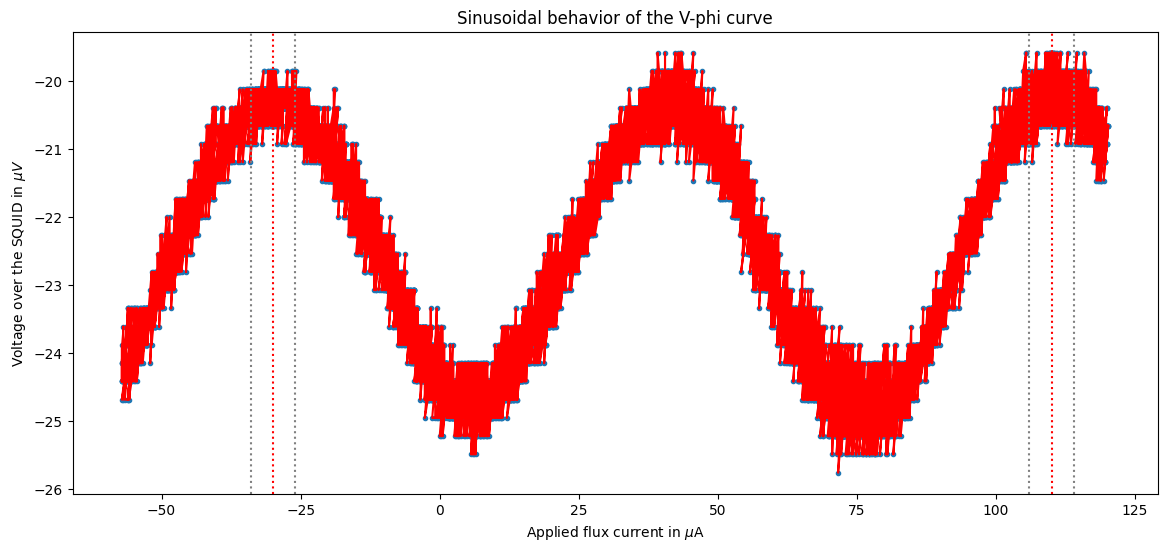

In [11]:
left_bound=-30
right_bound=110

plt.figure(figsize=(14,6))
plt.plot(i_5,v_5,'.',label='time $s$')
plt.plot(i_5,v_5,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_5=right_bound-left_bound
N_5=2

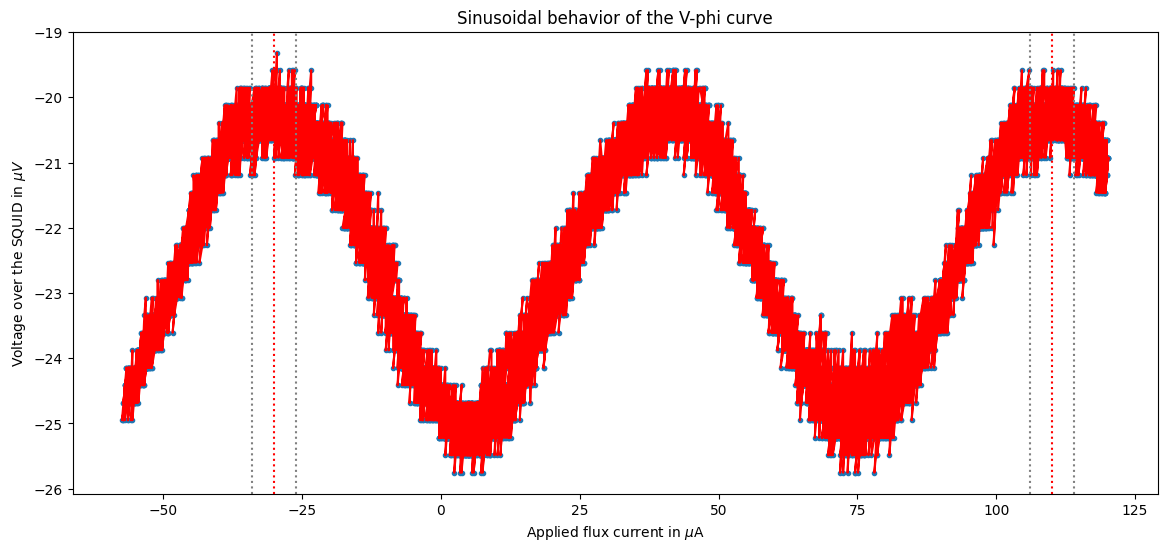

In [12]:
left_bound=-30
right_bound=110

plt.figure(figsize=(14,6))
plt.plot(i_6,v_6,'.',label='time $s$')
plt.plot(i_6,v_6,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_6=right_bound-left_bound
N_6=2

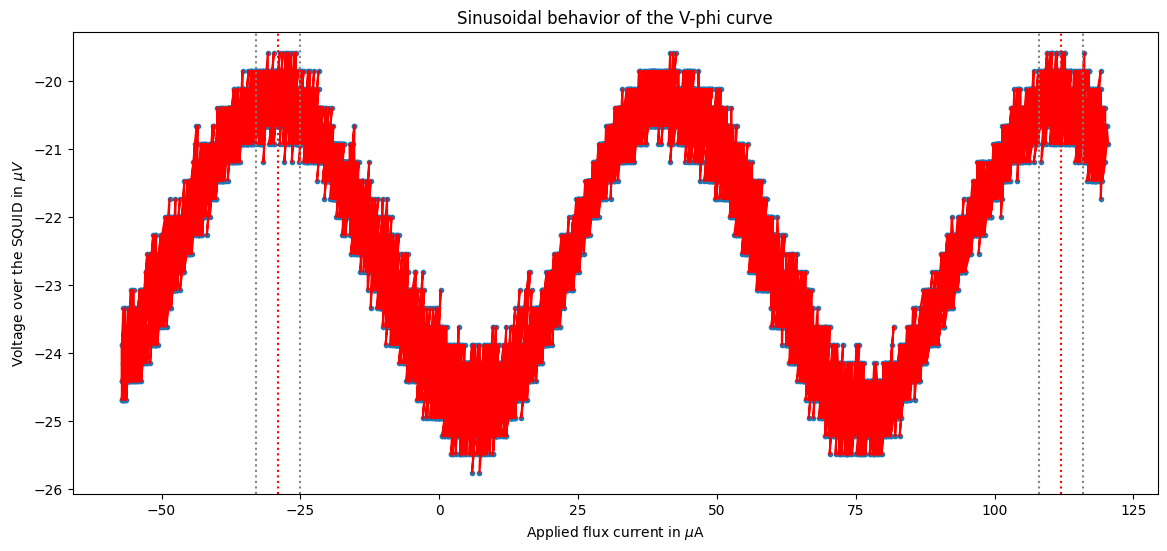

In [13]:
left_bound=-29
right_bound=112

plt.figure(figsize=(14,6))
plt.plot(i_7,v_7,'.',label='time $s$')
plt.plot(i_7,v_7,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_7=right_bound-left_bound
N_7=2

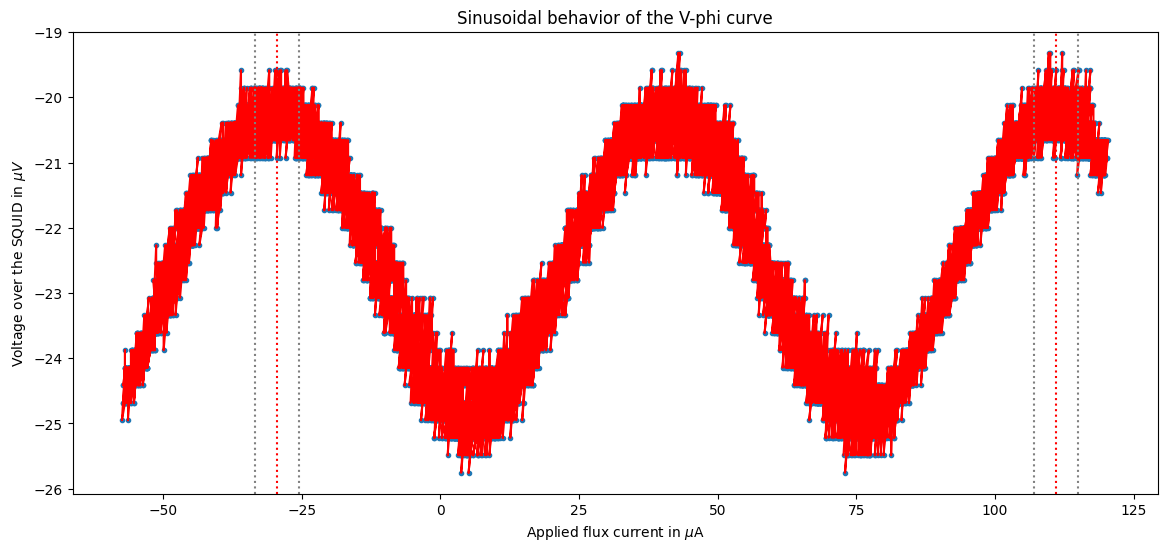

In [14]:
left_bound=-29.5
right_bound=111

plt.figure(figsize=(14,6))
plt.plot(i_8,v_8,'.',label='time $s$')
plt.plot(i_8,v_8,'r',label='Interpolated data')
plt.axvline(left_bound,ls=':',c="red")
plt.axvline(left_bound+u_I,ls=':',c="grey")
plt.axvline(left_bound-u_I,ls=':',c="grey")

plt.axvline(right_bound,ls=':',c="red")
plt.axvline(right_bound+u_I,ls=':',c="grey")
plt.axvline(right_bound-u_I,ls=':',c="grey")
plt.title('Sinusoidal behavior of the V-phi curve')
plt.xlabel('Applied flux current in $\mu$A')
plt.ylabel("Voltage over the SQUID in $\mu V$")
plt.show()
dI_8=right_bound-left_bound
N_8=2

In [15]:
dI_total=np.array([dI_0,dI_1,dI_2,dI_3,dI_4,dI_5,dI_6,dI_7,dI_8])
N_total=np.array([N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8])
#the uncertainty is the same each time, 8 microamps
u_dI_total=8*np.ones(9)
print(dI_total)
print(N_total)
dI=dI_total/N_total
u_dI=u_dI_total/N_total
print(dI)
print(u_dI)
print(np.mean(dI))
print(np.mean( (dI+u_dI) - (dI-u_dI) )/2)

[244.5 244.5 243.  244.  142.  140.  140.  141.  140.5]
[3.5 3.5 3.5 3.5 2.  2.  2.  2.  2. ]
[69.85714286 69.85714286 69.42857143 69.71428571 71.         70.
 70.         70.5        70.25      ]
[2.28571429 2.28571429 2.28571429 2.28571429 4.         4.
 4.         4.         4.        ]
70.06746031746032
3.238095238095241


So the value of $\Delta I$ is $70 \pm 3 \mu A$
That means that the self inductance M is $\approx 2*10^{-15}/7*10^{-5} = 29pH$.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7f259f03-5088-4677-bb0a-bf6373cc6341' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>